# Dynamics Simulations

In [2]:
from bioreaction.simulation.simfuncs.basic_de import bioreaction_sim_expanded
from bioreaction.model.data_tools import construct_model_fromnames
from bioreaction.simulation.basic_sim import convert_model

import diffrax as dfx
import jax
import pandas as pd
import numpy as np
from scipy import integrate
from functools import partial

import matplotlib.pyplot as plt
import seaborn as sns
jax.config.update('jax_platform_name', 'cpu')

# from src.utils.misc.units import per_mol_to_per_molecule
def per_mol_to_per_molecule(per_mol):
    """ Translate a value from the unit of per moles to per molecules.
    The number of M of mRNA in a cell was calculated using the average 
    number of mRNA in an E. coli cell (100 molecules) and the average volume of an E.
    coli cell (1.1e-15 L) to give ca. 1 molecule ~ 1.50958097 nM ~ 1.50958097e-9 M"""
    # 1/mol to 1/molecule
    # return np.divide(jmol, SCIENTIFIC['mole'])
    return np.multiply(per_mol, 1.50958097/np.power(10, 9))


In [7]:
num_species = 3

Keq = np.array(
    [[1, 2, 1],
     [2, 1, 0.5],
     [1, 0.5, 2]]
) 
# From src/utils/common/configs/RNA_circuit/molecular_params.json
a = np.ones(3) * 0.08333        # Creation rate
d = np.ones(3) * 0.0008333      # Degradation rate
ka = np.ones_like(Keq) * per_mol_to_per_molecule(1000000)   # Association rate
kd = ka/Keq     # Dissociation rate

model = construct_model_fromnames([str(i) for i in range(num_species)])
model.species = model.species[-num_species:] + model.species[:-num_species]


def update_model_rates(model, a=None, d=None, ka=None, kd=None):
    for i, r in enumerate(model.reactions):
        if not r.input:  # 0 -> RNA
            if a is not None:
                model.reactions[i].forward_rate = a[model.species.index(
                    r.output[0])]
                model.reactions[i].reverse_rate = 0
        elif not r.output:  # RNA -> 0
            if d is not None:
                model.reactions[i].forward_rate = d[model.species.index(
                    r.input[0])]
                model.reactions[i].reverse_rate = 0
        else:
            if ka is not None:
                model.reactions[i].forward_rate = ka[model.species.index(r.input[0]),
                                                     model.species.index(r.input[1])]
            if kd is not None:
                model.reactions[i].reverse_rate = kd[model.species.index(r.input[0]),
                                                     model.species.index(r.input[1])]
    return model


model = update_model_rates(model, a, d, ka, kd)
sim_model = convert_model(model)

m = np.max([sim_model.forward_rates.max(), sim_model.reverse_rates.max()])
y0 = np.concatenate(
    [np.array([1.0, 1.0, 1.0]), np.zeros(len(model.species[num_species:]))])
t0 = 0.0
t1 = 12000.0
dt0 = 1
inputs = sim_model.inputs
outputs = sim_model.outputs
forward_rates = sim_model.forward_rates/m
reverse_rates = sim_model.reverse_rates/m
batch = 40
reverse_rates = reverse_rates * \
    np.ones((batch, sim_model.reverse_rates.shape[0]))
reverse_rates = reverse_rates * np.random.random(reverse_rates.shape)
signal = None
signal_onehot = None
solver = dfx.Tsit5()
saveat = dfx.SaveAt(
    t0=True, t1=True, steps=True)
max_steps = 16**5


def bioreaction_sim_dfx_expanded(y0, t0, t1, dt0,
                                 inputs, outputs, forward_rates, reverse_rates,
                                 signal, signal_onehot: np.ndarray,
                                 solver=dfx.Tsit5(),
                                 saveat=dfx.SaveAt(
                                     t0=True, t1=True, steps=True),
                                 max_steps=16**5):
    term = dfx.ODETerm(
        partial(bioreaction_sim_expanded,
                inputs=inputs, outputs=outputs,
                forward_rates=forward_rates, reverse_rates=reverse_rates
                )
    )
    return dfx.diffeqsolve(term, solver,
                           t0=t0, t1=t1, dt0=dt0,
                           y0=y0,
                           saveat=saveat, max_steps=max_steps,
                           stepsize_controller=dfx.PIDController(rtol=1e-3, atol=1e-6))  # 16**4)


x = jax.jit(jax.vmap(partial(
    bioreaction_sim_dfx_expanded,
    y0=y0,
    t0=0.0,
    t1=12000.0,
    dt0=1,
    inputs=sim_model.inputs,
    outputs=sim_model.outputs,
    forward_rates=sim_model.forward_rates/m,
    reverse_rates=sim_model.reverse_rates/m,
    signal=None,
    signal_onehot=None,
    solver=dfx.Tsit5(),
    saveat=dfx.SaveAt(
        t0=True, t1=True, steps=True),
    max_steps=16**5,
)))(reverse_rates=reverse_rates)


In [8]:
np.unique(kd)

array([0.00075479, 0.00150958, 0.00301916])

In [9]:
x.stats['num_accepted_steps']

Array([11441, 10579,  9632, 11070, 12392, 10140, 10548, 12276, 10634,
        9523,  5101, 10209,  9460, 10367,  7790, 10195,  7526, 11388,
       10101,  8520, 10114, 11485,  8988,  9759, 11266,  9143, 10951,
       10495,  7227,  9693,  9152, 12697,  6989, 10532,  8675,  9877,
       10613, 11004, 11642,  8704], dtype=int32, weak_type=True)

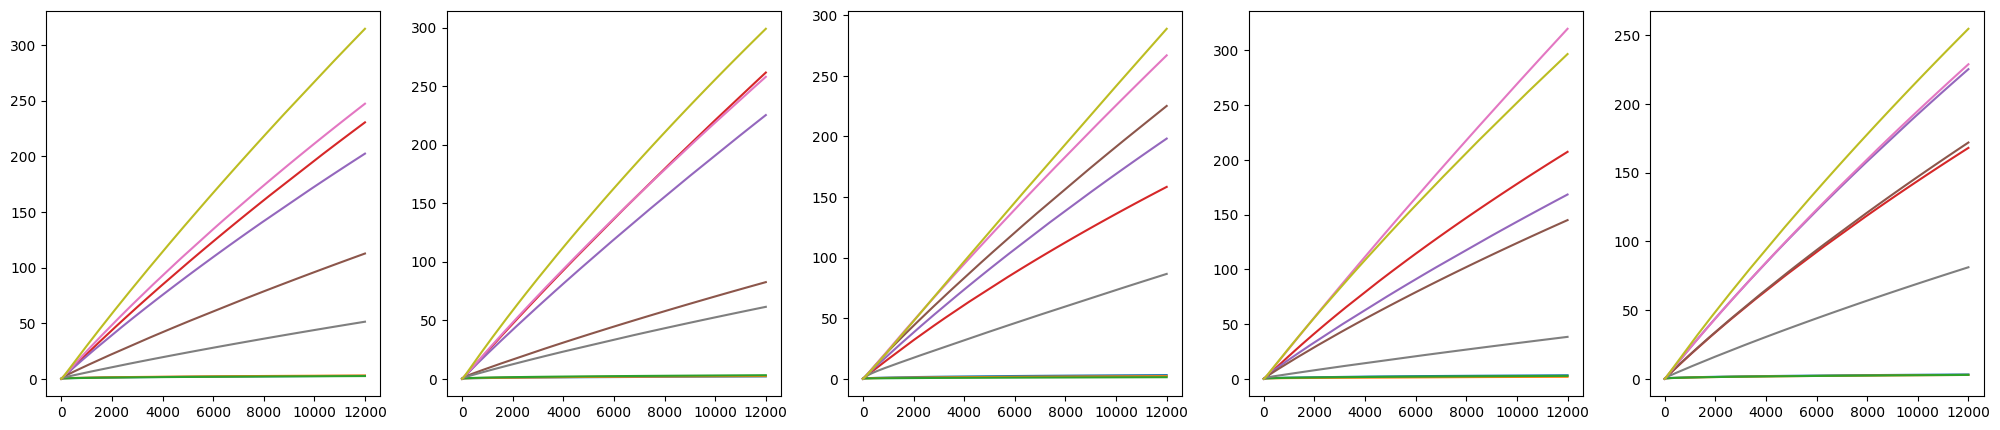

In [10]:
b = 5
plt.figure(figsize=(5*b, 5))
for i in range(b):
# i = 1
    ax = plt.subplot(1,b, i+1)
    plt.plot(x.ts[i], (x.ys*m)[i])

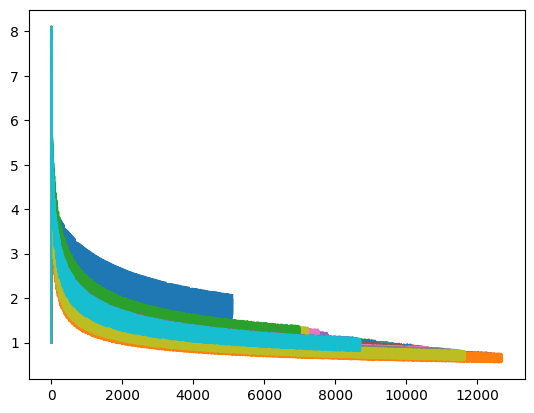

In [11]:
t = np.array(x.ts) #.mean(axis=0)

for i, tacc in enumerate(x.stats['num_accepted_steps']):
    plt.plot(t[i, 1:tacc] - t[i, :tacc-1])
    